In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import bisect

In [2]:
def timer(f):
    
    def countTime(*args, **kwargs):
        print("Start simulating...")
        s = time.time()
        res = f(*args, **kwargs)
        e = time.time()
        print("End simulating.")
        print("Processed in %f seconds." %(e-s))
        return res
    
    return countTime

In [3]:
@timer
def monteCarlo(points: int, mult: int, weights: np.array, steps: int) -> np.array:
    """
    weights为权重向量，最小值应为0，最大值应为1
    """
    dimension = len(weights)
    alpha = np.ones(dimension)*mult/2
    rvec = np.random.dirichlet(alpha, size = points)
    col = np.dot(rvec, weights)
    return col

In [21]:
points = 10**6
mult = 1
weights = np.array([0, 0, 0.6, 0.6, 1,  1])
steps = 10**6

Start simulating...
End simulating.
Processed in 1.109337 seconds.


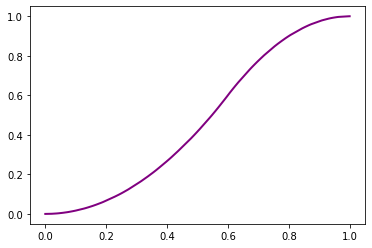

In [23]:
col = monteCarlo(points,mult,weights,steps)
col.sort()
x = np.linspace(0, 1, steps)
y = col
plt.plot(y, x, ls = "-", lw = 2, color = "purple")
plt.show()